## What are the features in this data?
* Each instance is a school.

## Graduation rate is given by two features--Cohort and Rate--for each subpopulation below.
* Cohort - Number of students in that subpopulation
* Rate - Percentage (or range of percentage) of students in the cohort graduating with a high school diploma within 4 years

## School identifiers
* STNAM  - State name
* FIPST  - 2 digit code for the state
* LEANM  - School district name
* LEAID  - 7 digit code for school district 
* SCHNAM - School name
* NCESSH - 12 digit school id (only unique identifier for a school)


## Subpopulations
* ALL 	= All students in the school
* MAM 	= American Indian/Alaska   Native students
* MAS 	= Asian/Pacific Islander students
* MHI 	= Hispanic students
* MBL 	= Black students
* MWH 	= White students
* MTR 	= Two or More Races
* CWD 	= Children with Disabilities (IDEA)
* ECD 	= Economically Disadvantaged students
* LEP 	= Limited English Proficient students


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from swampy import structshape as ss
import sys
sys.path.append("..")
from ingest import gr

In [2]:
dfs = [gr.make_raw_gr_frame(year=y) for y in range(2010, 2019)]
years = [gr.year_string(y) for y in range(2010, 2019)]

In [3]:
# Many of the column names have the school year in them, which presents a challenge for combining all the years 
# into one large dataframe.
print(dfs[0].columns)

Index(['STNAM', 'FIPST', 'LEAID', 'LEANM', 'NCESSCH', 'SCHNAM',
       'ALL_COHORT_1011', 'ALL_RATE_1011', 'MAM_COHORT_1011', 'MAM_RATE_1011',
       'MAS_COHORT_1011', 'MAS_RATE_1011', 'MBL_COHORT_1011', 'MBL_RATE_1011',
       'MHI_COHORT_1011', 'MHI_RATE_1011', 'MTR_COHORT_1011', 'MTR_RATE_1011',
       'MWH_COHORT_1011', 'MWH_RATE_1011', 'CWD_COHORT_1011', 'CWD_RATE_1011',
       'ECD_COHORT_1011', 'ECD_RATE_1011', 'LEP_COHORT_1011', 'LEP_RATE_1011',
       'DATE_CUR'],
      dtype='object')


### Reshaping the data from different years to so that they can be combined into one large dataset. 

In [4]:
shape_data = [(school_year, df.shape) for school_year, df in zip(years, dfs)]
shape = pd.DataFrame(shape_data, columns=('school_year', 'shape'))
shape


,school_year,shape
0,1011,"(21335, 27)"
1,1112,"(21244, 27)"
2,1213,"(22077, 27)"
3,1314,"(22385, 28)"
4,1415,"(22167, 27)"
5,1516,"(23090, 27)"
6,1617,"(23129, 29)"
7,1718,"(23240, 33)"
8,1819,"(22900, 33)"


In [5]:
# Inspect features that are present in some but not common to all.
# Start by removing the years from the column names.
# cols_wo_year => Column names without the year
cols_wo_year = [list(map(lambda x: x.replace(y, ""), df.columns))
               for y, df in zip(years, dfs)]
print(set(cols_wo_year[3]) - set(cols_wo_year[0]))
print(set(cols_wo_year[6]) - set(cols_wo_year[0]))
print(set(cols_wo_year[7]) - set(cols_wo_year[0]))
print(set(cols_wo_year[8]) - set(cols_wo_year[0]))

{'INSERT_DATE'}
{'ST_LEAID', 'ST_SCHID'}
{'ST_LEAID', 'HOM_COHORT_', 'ST_SCHID', 'FCS_COHORT_', 'HOM_RATE_', 'FCS_RATE_'}
{'ST_LEAID', 'HOM_COHORT_', 'ST_SCHID', 'FCS_COHORT_', 'HOM_RATE_', 'FCS_RATE_'}


In [6]:
# INSERT_DATE refers to when the data was inserted and is not relevant for our study.
dfs[3].drop(['INSERT_DATE'], axis=1, inplace=True)
# ST_SCHID and ST_LEAID are values assigned by the state which are not found in the other years. From the data, it looks like maybe these
# started being assigned in 2016. If we need another geographical grouping mechanism in the future we can look into it.
dfs[6].drop(['ST_LEAID', 'ST_SCHID'], axis=1, inplace=True)
# HOM_COHORT and FCS_COHORT refer to the subpopulation of homeless and foster care students, which was not tracked before school year 2017-2018
idx7_sr = shape.school_year[7]
idx8_sr = shape.school_year[8]
dfs[7].drop(['ST_LEAID', 'ST_SCHID', 'FCS_RATE_'+idx7_sr, 'FCS_COHORT_'+idx7_sr,
            'HOM_RATE_'+idx7_sr, 'HOM_COHORT_'+idx7_sr], axis=1, inplace=True)
dfs[8].drop(['ST_LEAID', 'ST_SCHID', 'FCS_RATE_'+idx8_sr, 'FCS_COHORT_'+idx8_sr,
            'HOM_RATE_'+idx8_sr, 'HOM_COHORT_'+idx8_sr], axis=1, inplace=True)


In [7]:
# Verify that all dataframes have the same columns (minus the school year) before we combine. 
cols_wo_school_year = [list(map(lambda x: x.replace(y, ""), df.columns))
               for y, df in zip(years, dfs)]
for num1,num2 in zip(range(0,8),range(1,9)):
    assert cols_wo_school_year[num1] == cols_wo_school_year[num2] 

In [8]:
big_df = pd.DataFrame()
print("big_df_columns",big_df.columns)
for idx, df in enumerate(dfs):
    df.columns=cols_wo_school_year[0]
    df['Year'] = years[idx] 
    # reorder columns to be how we want
    df = df[['Year']+cols_wo_school_year[0]]
    big_df = pd.concat([big_df,df],axis=0)


big_df_columns Index([], dtype='object')


In [9]:
big_df.shape, big_df.head(n=3)

((201567, 28),
    Year    STNAM  FIPST   LEAID             LEANM      NCESSCH  \
 0  1011  ALABAMA      1  100005  Albertville City  10000500871   
 1  1011  ALABAMA      1  100006   Marshall County  10000600872   
 2  1011  ALABAMA      1  100006   Marshall County  10000600878   
 
                  SCHNAM ALL_COHORT_ ALL_RATE_ MAM_COHORT_  ... MTR_RATE_  \
 0  Albertville High Sch         252        80           .  ...         .   
 1            Asbury Sch          57     70-79           .  ...         .   
 2      Douglas High Sch         125     65-69           2  ...         .   
 
   MWH_COHORT_ MWH_RATE_ CWD_COHORT_ CWD_RATE_ ECD_COHORT_ ECD_RATE_  \
 0         184     80-84           3        PS         121     65-69   
 1          48     70-79           7      GE50          31     60-69   
 2         105     70-74          13      GE50          92     60-64   
 
   LEP_COHORT_ LEP_RATE_ DATE_CUR  
 0          10      LT50  03OCT15  
 1           3        PS  03OCT15  
 2     

In [10]:
df_info = pd.DataFrame(columns=['% Null', '% Unique'])
df_info['% Null'] = big_df.isnull().sum() / len(big_df) * 100
df_info['% Unique'] = big_df.nunique() / len(big_df) * 100
df_info

,% Null,% Unique
Year,0.000000,0.004465
STNAM,0.000000,0.026790
FIPST,0.000000,0.026294
LEAID,0.000000,6.747136
LEANM,0.000000,7.671395
NCESSCH,0.000000,14.401167
SCHNAM,0.000000,15.943582
ALL_COHORT_,0.000000,1.121215
ALL_RATE_,0.000000,0.067967
MAM_COHORT_,24.116547,0.157764


Text(0, 0.5, '% Null')

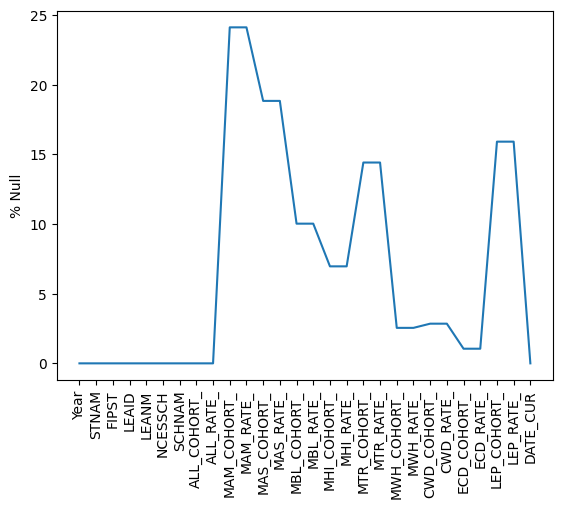

In [11]:
plt.plot(range(big_df.columns.size),(big_df.isnull().sum() / len(big_df) * 100).values)
plt.xticks(ticks=list(range(big_df.columns.size)),labels=big_df.columns.tolist(),rotation=90)
plt.ylabel('% Null')
# MAMs, MAS, LEP, and MTR are the subpopulations with the largest number of missing values.

### The missing data in the subpopulation columns presents a problem for performing machine learning on this data.
* The Adjusted Cohort Graduation Rate codebook gives the following Q&A:
#### Why doesn’t the summation of the major racial and ethnic groups equal the “ALL” student count?
* Due to flexibilities with states’ implementation of the Elementary and Secondary Education Act,
  there may be instances where not all possible groupings of racial/ethnic identification are reported
  as individual subgroups. Therefore, some information may be missing and these counts by major racial
  and ethnic group will not include every student; however any students not included within an individual
  major racial and ethnic group would be included in the “ALL” student count.
#### Why are the major racial and ethnic groups reported differently by states?
* Under the ESEA, a State educational agency (SEA) has the flexibility to determine the major racial/ethnic
  groups it will use for reporting on the data included in its assessment and accountability system.  The
  subgroups that an SEA uses are approved through its Accountability Workbook (the most recent copy of each
  state’s workbook can be found here:  http://www2.ed.gov/admins/lead/account/stateplans03/index.html).
  As a result, there is some variation in how SEAs report data by race and ethnicity. 
### As a first step, we are going to look at prediction models which do not include minority groupings of the students.

In [12]:
# Drop population subgroup columns
cols_to_keep = ['Year','STNAM','FIPST','LEAID','LEANM','NCESSCH','SCHNAM','ALL_COHORT_','ALL_RATE_']
big_df = big_df[cols_to_keep]

# Feature pre-processing
* Year, ALL_COHORT_, and ALL_RATE_ are numeric columns which are strings (objects) in the raw data.

In [13]:
# Several columns are of object type, which means that either text or Nan values are present.
def print_object_column_info(df):
    """
    Print column data types and the number of object columns.
    """
    print(big_df.dtypes, "{} object columns present". format(len(big_df.select_dtypes(include=object).count())))

print_object_column_info(big_df)

Year           object
STNAM          object
FIPST           int64
LEAID           int64
LEANM          object
NCESSCH         int64
SCHNAM         object
ALL_COHORT_    object
ALL_RATE_      object
dtype: object 6 object columns present


In [14]:
big_df.select_dtypes(include=object)

,Year,STNAM,LEANM,SCHNAM,ALL_COHORT_,ALL_RATE_
0,1011,ALABAMA,Albertville City,Albertville High Sch,252,80
1,1011,ALABAMA,Marshall County,Asbury Sch,57,70-79
2,1011,ALABAMA,Marshall County,Douglas High Sch,125,65-69
3,1011,ALABAMA,Marshall County,Kate D Smith DAR High Sch,121,80-84
4,1011,ALABAMA,Marshall County,Brindlee Mt High Sch,94,75-79
...,...,...,...,...,...,...
22895,1819,WYOMING,Washakie County School District #2,Ten Sleep K-12,8,GE50
22896,1819,WYOMING,Teton County School District #1,Jackson Hole High School,163,GE95
22897,1819,WYOMING,Teton County School District #1,Summit Innovations School,20,GE80
22898,1819,WYOMING,Weston County School District #7,Upton High School,25,60-79


In [15]:
# Convert year feature to numeric
big_df.loc[:,'Year'] = np.int64(big_df.Year)
print_object_column_info(big_df)

Year            int64
STNAM          object
FIPST           int64
LEAID           int64
LEANM          object
NCESSCH         int64
SCHNAM         object
ALL_COHORT_    object
ALL_RATE_      object
dtype: object 5 object columns present


/tmp/ipykernel_547225/1914344552.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  big_df.loc[:,'Year'] = np.int64(big_df.Year)


In [19]:
big_df.ALL_COHORT_.describe(), big_df.ALL_RATE_.describe()

(count     201567
 unique      2260
 top            .
 freq        2913
 Name: ALL_COHORT_, dtype: object,
 count     201567
 unique       137
 top         GE95
 freq       15889
 Name: ALL_RATE_, dtype: object)